<a href="https://colab.research.google.com/github/paulyea/notesbooks/blob/main/rp_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Risk Premia Harvesting Simulation

We'll simulate trading a simple risk premia harvesting strategy

The objectives of simulation are generally to:

- Understand whether an edge can be practically exploited with simple trading rules
- Assist in navigating various operational trade-offs, such as design of the actual rules to harness the edge, how actively to rebalance positions, the impact of leverage etc.

In this notebook we'll do the following:

- Set up a simulation and get familiar with our simulation tools
- Delve into simulated performance of a simple set of trading rules
- Experiment with trading rules and operational decisions to navigate trade-offs such as:
  - How actively to rebalance positions
  - Accessing leverage via margin borrowing and through leveraged ETFs.

In [ ]:
# setup
# pacman not on apt
install.packages("pacman")

# lists of libraries: rwRtools dependencies (install but don't load) and libs_to_load (install and load)
dependencies <- c(
  "ttr", "googleauthr", "doparallel", "googlecloudstorager", "dplyr",
  "iterators", "R.methodsS3", "openssl", "foreach", "xts", "R.oo", "feather", 
  "R.utils", "RcppArmadillo", "slam", "timeDate", "cccp", "Rglpk", "timeSeries",
  "tibble", "tidyr", "stringr", "magrittr", "ggplot2", "here", "roll", "Rcpp"
)
libs_to_load <- c("tidyverse", "lubridate", "purrr", "zoo", "glue", "slider", "patchwork", "stringr")

# capitalisation of call to CRAN may not always match capitalisation of package name (eg library(doParallel) vs sudo apt install r-cran-doparallel).
install_from_cran <- gsub("^(?!R\\.)([\\w]+)", "\\L\\1", c(libs_to_load, dependencies), perl = TRUE)  # convert to lowercase all letters other than an "R" at the start followed by "."

msg1 <- system2('sudo', args = c('apt-get', 'update'),
  stdout = TRUE,
  stderr = TRUE,
  wait = TRUE
)

msg2 <- system2(
  'sudo', 
  args = c('apt', 'install', sub('', 'r-cran-', install_from_cran, '-y --fix-missing')),
  stdout = TRUE,
  stderr = TRUE,
  wait = TRUE
)

pacman::p_load(char = libs_to_load, install = FALSE)

# install and load rsims from GH (sans dependencies)
pacman::p_load_current_gh("Robot-Wealth/rsims", dependencies = FALSE)

# output messages from install - optional, for debugging
# msg

# Set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpnqeL34/remotes8346ec4755/Robot-Wealth-rsims-2589683/DESCRIPTION’ ... OK
* preparing ‘rsims’:
* checking DESCRIPTION meta-information ... OK
* cleaning src
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘rsims_1.1.0.4.tar.gz’



# What data do we need for backtesting?

`rsims` typically needs the following data for backtesting:
- Wide matrix of trade prices (ie the prices you assume you can trade at), one ticker per column
- Wide matrix of target weights, one column per ticker, same dimensions as prices matrix. Date-aligned with the price you assume you trade at.
- Wide matrix of unadjusted prices. Need this for commission calculations which are based on actual number and/or value of shares traded. 
- Matrix of daily interest rates applied to cash balance (defaults to zero if not supplied)
- Vector of short borrow costs by ticker (defaults to zero if not supplied)
- A function that models your commission structure plus its arguments.
- An initial cash balance
- Whether to continuously capitalise profits into target position.

The biggest challenges are defining your target weights, and then wrangling prices and target weights such that they are aligned correctly. 

However, the former is usually a natural output of a quant research process, and the latter can be made relatively simple with `tidyverse` data wrangling, or `rsims` helper functions. 

## Get Price Data

We'll get our data from yahoo. Here's a helper function to make this easy:

In [ ]:
get_yahoo_prices <- function(ticker) {
  prices <- read_csv(glue::glue("https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1=728352000&period2=1656979200&interval=1d&events=history&includeAdjustedClose=true"))
  prices %>% mutate(Ticker = ticker)
}

In [ ]:
tickers <- c("VTI", "TLT", "GLD")
prices <- map_dfr(.x = tickers, .f = ~get_yahoo_prices(.)) %>%
  arrange(Date, Ticker)

tail(prices)

Rows: 5295 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (6): Open, High, Low, Close, Adj Close, Volume
date (1): Date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 5017 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (6): Open, High, Low, Close, Adj Close, Volume
date (1): Date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 4435 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (6): Open, High, Low, Close, Adj Close, Volume
date (1): Date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to 

Date,Open,High,Low,Close,Adj Close,Volume,Ticker
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
2022-06-30,169.51,169.96,168.24,168.46,168.4600,9144400,GLD
2022-06-30,114.86,115.77,114.75,114.87,112.5310,25802100,TLT
2022-06-30,188.00,190.31,186.13,188.62,186.9214,4250300,VTI
2022-07-01,167.14,168.68,166.96,168.32,168.3200,11380300,GLD
2022-07-01,115.90,117.59,115.22,115.82,113.6863,21858800,TLT
2022-07-01,188.19,190.87,186.90,190.61,188.8935,3223100,VTI


Make sure our prices looks sensible.

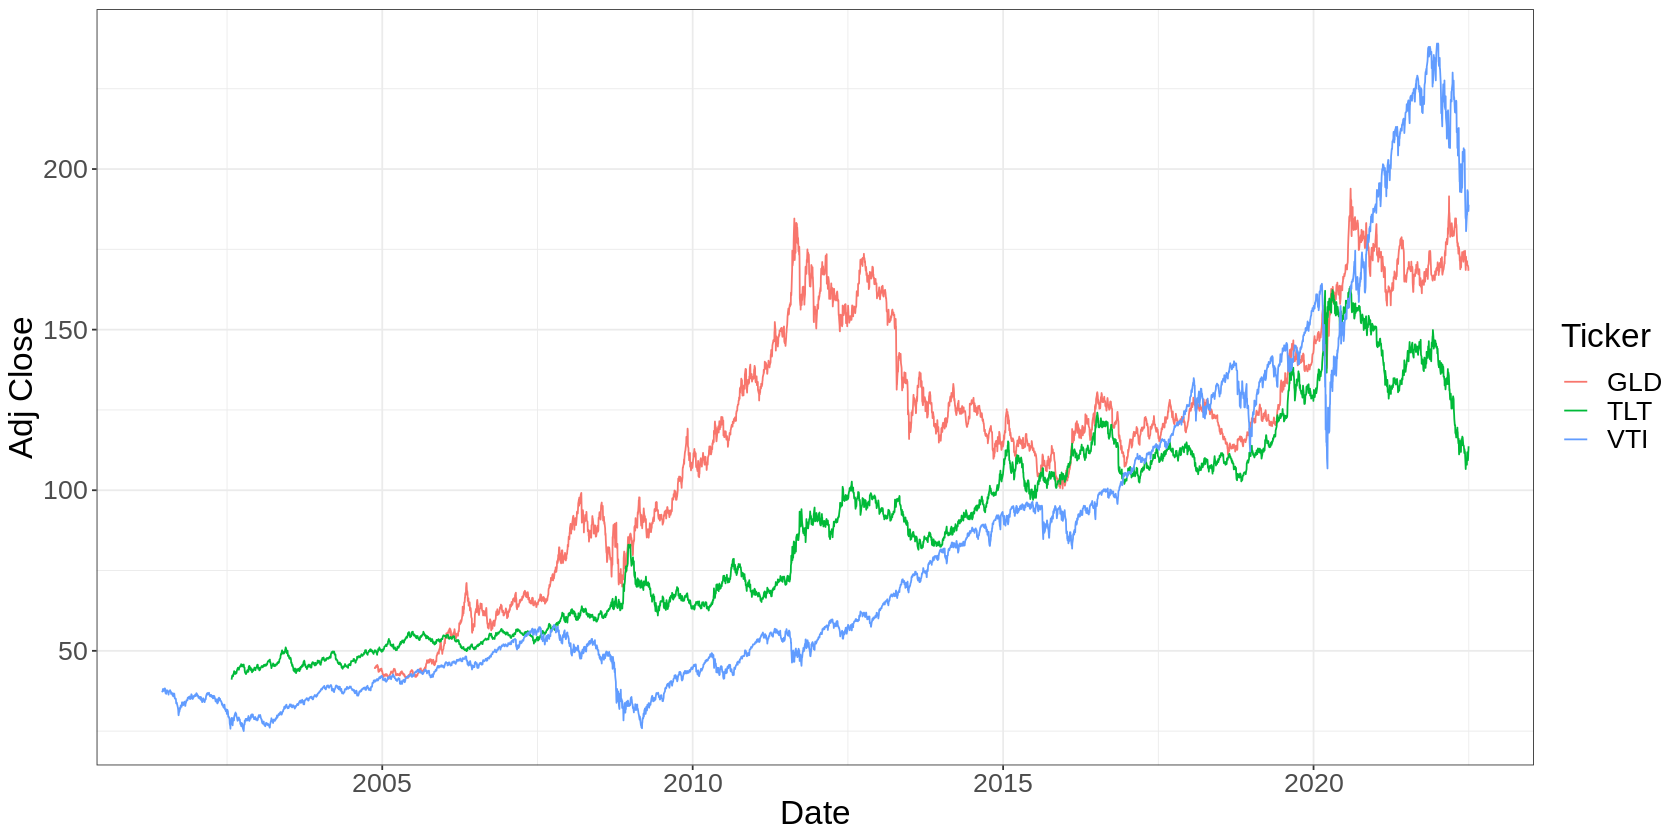

In [ ]:
prices %>%
  ggplot(aes(x = Date, y = `Adj Close`, colour = Ticker)) +
    geom_line() 

Note our data starts on different dates for our different tickers. We'll simulate from the latest of these start dates. 

In [ ]:
start_date <- prices %>%
  group_by(Ticker) %>%
  summarise(start = first(Date)) %>%
  pull(start) %>%
  max()

prices <- prices %>%
  filter(Date >= start_date)

head(prices)

Date,Open,High,Low,Close,Adj Close,Volume,Ticker
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
2004-11-18,44.430,44.490,44.070,44.380,44.38000,5992000,GLD
2004-11-18,88.550,89.060,88.410,88.970,50.17880,891500,TLT
2004-11-18,57.500,57.675,57.405,57.675,40.84974,125000,VTI
2004-11-19,44.490,44.920,44.470,44.780,44.78000,11655300,GLD
2004-11-19,88.900,89.030,88.090,88.260,49.77832,1244500,TLT
2004-11-19,57.575,57.650,56.885,56.975,40.35395,799800,VTI


So we don't have to worry about splits and dividends, we will simulate trading at dividend and split adjusted close prices (Adj Close) - but we will calculate commission calculations from unadjusted data.

## Define RP target weights

Our strategy is very simple. 

We'll target the following weights in our RP strategy:
- VTI: 50%
- TLT: 35%
- GLD: 15%

For now, we'll treat this as if we were 100% invested in RP.

In [ ]:
target_weights <- c("VTI" = 0.5, "TLT" = 0.35, "GLD" = 0.15)

backtest_df <- prices %>%
  mutate(rp_target_weight = case_when(
    Ticker == "VTI" ~ target_weights["VTI"],
    Ticker == "TLT" ~ target_weights["TLT"],
    Ticker == "GLD" ~ target_weights["GLD"],
  ))  %>%
  select(Ticker, Date, `Adj Close`, Close, rp_target_weight) # Just select the stuff we need

tail(backtest_df)

Ticker,Date,Adj Close,Close,rp_target_weight
<chr>,<date>,<dbl>,<dbl>,<dbl>
GLD,2022-06-30,168.4600,168.46,0.15
TLT,2022-06-30,112.5310,114.87,0.35
VTI,2022-06-30,186.9214,188.62,0.50
GLD,2022-07-01,168.3200,168.32,0.15
TLT,2022-07-01,113.6863,115.82,0.35
VTI,2022-07-01,188.8935,190.61,0.50


### Create tradeable (adjusted) prices matrix



In [ ]:
# prices
sim_prices <- backtest_df %>%
  select(Ticker, Date, `Adj Close`) %>%
  pivot_wider(id_cols = Date, names_from = Ticker, values_from = `Adj Close`) %>%
  data.matrix()

head(sim_prices)

Date,GLD,TLT,VTI
12740,44.38,50.17880,40.84974
12741,44.78,49.77832,40.35395
12744,44.95,50.03781,40.61954
12745,44.75,50.09981,40.63372
12746,45.05,50.09981,40.86744
12748,45.29,49.77272,40.86744


### Create Matrix of Asset Weights


In [ ]:
target_weights <- backtest_df %>%
  select(Ticker, Date, rp_target_weight) %>%
  pivot_wider(id_cols = Date, names_from = Ticker, values_from = rp_target_weight) %>%
  data.matrix()

head(target_weights)

Date,GLD,TLT,VTI
12740,0.15,0.35,0.5
12741,0.15,0.35,0.5
12744,0.15,0.35,0.5
12745,0.15,0.35,0.5
12746,0.15,0.35,0.5
12748,0.15,0.35,0.5


### Create unadjusted prices matrix (for commission calcs)

for accurately calculating historical commissions

In [ ]:
sim_unadj_prices <- backtest_df %>%
  select(Ticker, Date, Close) %>%
  pivot_wider(id_cols = Date, names_from = Ticker, values_from = Close) %>%
  data.matrix()

head(sim_unadj_prices)

Date,GLD,TLT,VTI
12740,44.38,88.97,57.675
12741,44.78,88.26,56.975
12744,44.95,88.72,57.350
12745,44.75,88.83,57.370
12746,45.05,88.83,57.700
12748,45.29,88.25,57.700


### Create interest rate matrix

For interest accrual on cash balances

We'll use 13-week t-bills as our benchmark interest rate.



In [ ]:
bills <- get_yahoo_prices("^IRX")

# wrangle bills data
bills <- bills %>%
  select(Date, Close) %>%
  mutate(across(.cols = Close, .fns = as.numeric)) %>%
  fill(Close, .direction = "down") %>%
  rename("rate" = Close)

backtest_df <- backtest_df %>%
  left_join(  # left joining on Date is a good way to filter the rates data on common dates
    bills,
    by = "Date"
  ) %>%
  mutate(
    rate = pmax(0, rate/(365*100)) # Convert annualised to daily pct
  )  

# matrix of interest rate data
interest_rates <- backtest_df %>%
  select(Date, rate) %>%
  data.matrix()

head(interest_rates)


Rows: 9075 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (6): Open, High, Low, Close, Adj Close, Volume
date (1): Date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `across(.cols = Close, .fns = as.numeric)`.
Caused by warning:
! NAs introduced by coercion”


Date,rate
12740,5.717808e-05
12740,5.717808e-05
12740,5.717808e-05
12741,5.742466e-05
12741,5.742466e-05
12741,5.742466e-05


## Simulation

`rsims` also has some other simulation paramters:
- `short_borrow_costs`: Named vector of annualised short borrow costs as percent. For example, c("TLT" = 0.0025) is equivalent to a short borrow cost of 0.25%pa TLT. Defaults to zero.
- `trade_buffer`: Position deltas are calculated using the trade buffer approach. Positions are rebalanced once they deviate from their target by more than `trade_buffer`. Rebalancing happens slightly differently depending on the commission model used:  
  - for minimum commission backtesting, rebalance back to the target weight
  - for fixed commission backtesting, rebalance back to the target weight plus/minus the trade buffer
- `initial_cash`: Inital cash balance for the simulation.
- `capitalise_profits`: If `TRUE`, utilise profits and initial cash balance in determining position sizes. If `FALSE`, profits accrue as a cash balance and are not reinvested.
- `commission_fun`: Function for determining commissions from prices and
trades. `rsims` includes various commission models, including `us_tiered_commission` which models IB's tiered commission structure for US equities.
- `...`: Additional arguments passed to commission_fun. For `us_tiered_commission`, this will be `max_pct_per_order` (the maximum commission as a percentage of order value), `min_dollars_per_order` (the minimum commission in dollars of a single order), `dollars_per_share` (the per-share cost in dollars - for IB fixed tier, 0.005 is reasonable).

First let's rebalance back to target weights if they get out by 5%

In [ ]:
# simulation
results_df <- min_commission_backtest(
  prices = sim_prices,
  unadjusted_prices = sim_unadj_prices,
  target_weights = target_weights,
  interest_rates = interest_rates,
  short_borrow_costs = c("GLD" = 0.4/100, "TLT" = 0.4/100, "VTI" = 0.4/100), # We're not actually doing any shorting
  trade_buffer = 0.05,
  initial_cash = 10000,
  capitalise_profits = FALSE,
  commission_fun = us_tiered_commission,
  max_pct_per_order = 0.01,
  min_dollars_per_order = 1,
  dollars_per_share = 0.005
)

head(results_df)

ticker,date,close,shares,exposure,share_trades,trade_value,commission,interest,short_borrow,margin_call,reduced_target_pos
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
Cash,2004-11-18,0.00000,0,86.88975,0,-9910.545,0,0.434794521,0,FALSE,FALSE
GLD,2004-11-18,44.38000,33,1464.54003,33,1464.540,1,0.000000000,0,FALSE,FALSE
TLT,2004-11-18,50.17880,69,3462.33686,69,3462.337,1,0.000000000,0,FALSE,FALSE
VTI,2004-11-18,40.84974,122,4983.66816,122,4983.668,1,0.000000000,0,FALSE,FALSE
Cash,2004-11-19,0.00000,0,86.89353,0,0.000,0,0.003777919,0,FALSE,FALSE
GLD,2004-11-19,44.78000,33,1477.73997,0,0.000,0,0.000000000,0,FALSE,FALSE


We can plot the % exposure we hold in each asset and the rebalance trades we make. 

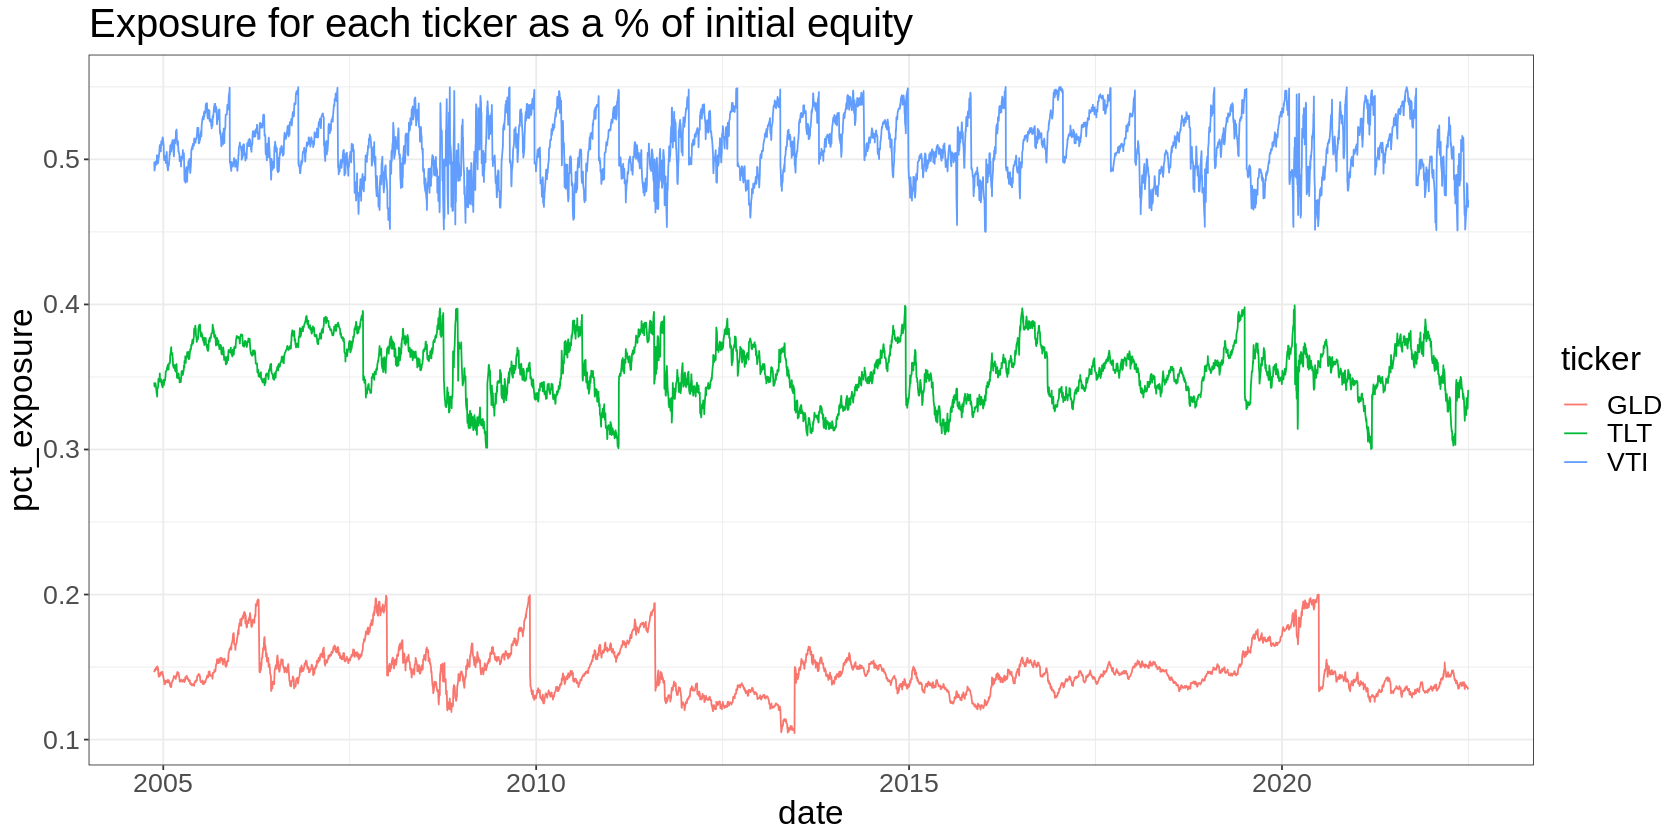

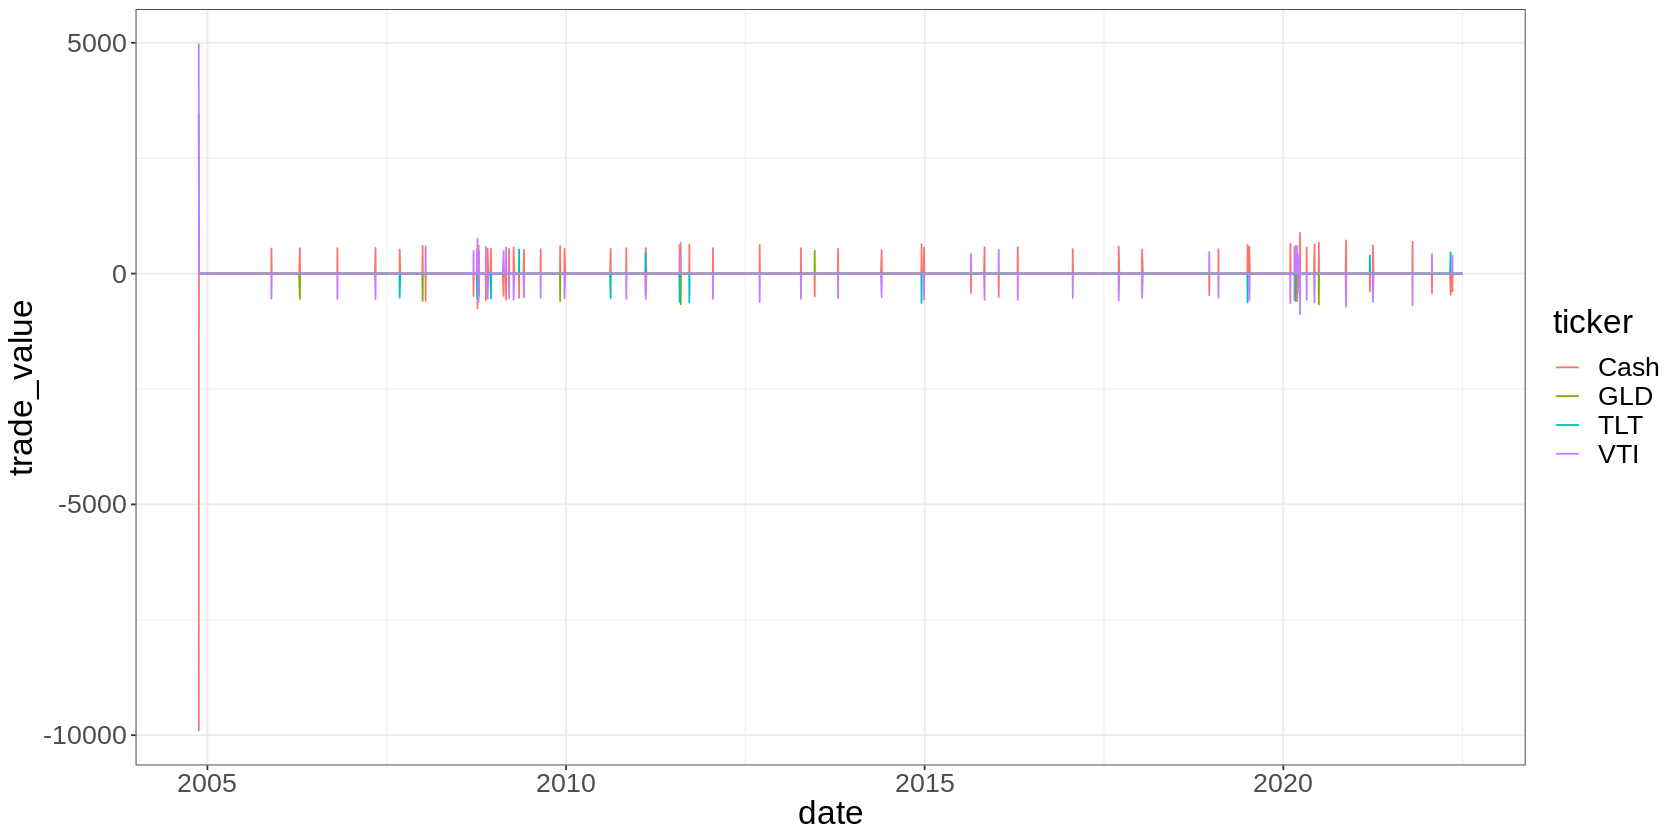

In [ ]:
results_df %>%
  mutate(pct_exposure = exposure/10000) %>%
  filter(!ticker=='Cash') %>%
  ggplot(aes(x=date, y=pct_exposure, color=ticker)) + geom_line() + ggtitle('Exposure for each ticker as a % of initial equity')

results_df %>%
   ggplot(aes(x=date, y=trade_value, color=ticker)) + geom_line()

You can see the rebalance trades moving the exposure back to target.

Let's plot our net asset value.

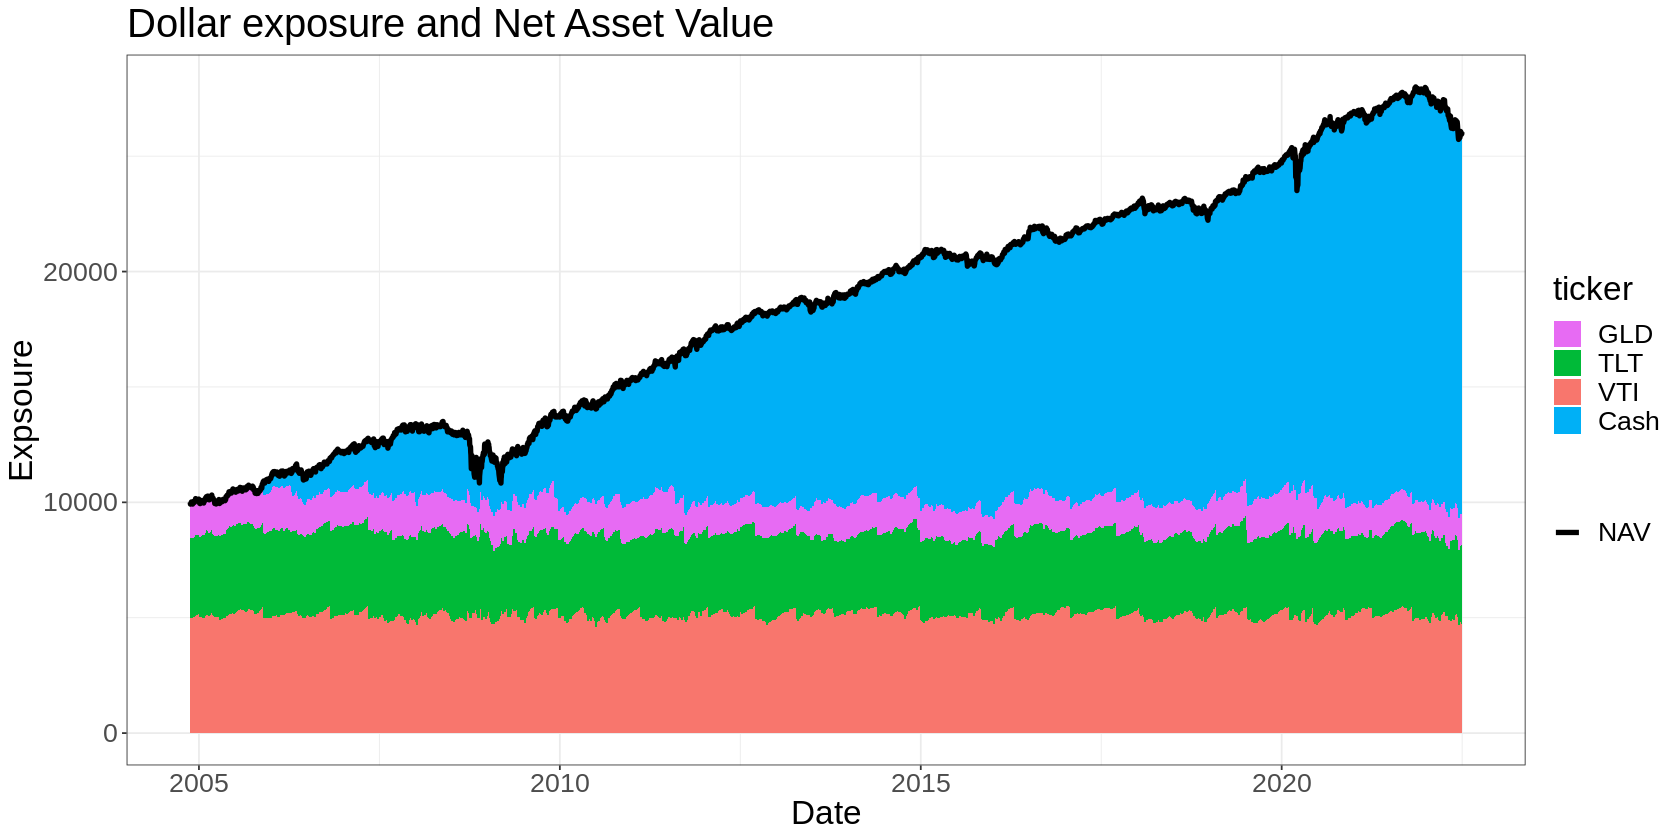

In [ ]:
# plot NAV and exposure by ticker
NAV <- results_df %>%
  group_by(date) %>%
  summarise(exposure = sum(exposure)) %>%
  mutate(ticker = "NAV")
  
NAV <- results_df %>%
  select(ticker, date, exposure) %>%
  bind_rows(NAV) %>%
  arrange(date, ticker) 
  
NAV %>%  
    filter(ticker != "NAV") %>%
    ggplot(aes(x = date, y = exposure, fill = ticker)) +
    geom_area() +
    scale_fill_manual(name = "ticker", values = c('#E76BF3', '#00BA38', '#F8766D', '#00b0f6'), limits = c('GLD', 'TLT', 'VTI', 'Cash')) +
    geom_line(data = NAV %>% dplyr::filter(ticker == "NAV"), aes(x = date, y = exposure, colour = "ticker"), linewidth = 1.5) +
    scale_colour_manual(values = "black", labels = "NAV") +
    labs(
      x = "Date",
      y = "Expsoure",
      title = "Dollar exposure and Net Asset Value",
      colour = ""
    )

You can see how cash is accumulated over time as we make money. (We are not re-investing profits here.)

Let's look at summary stats.

In [ ]:
# summary stats
NAV %>%
  filter(ticker == "NAV") %>%
  arrange(date) %>%
  mutate(returns = log(exposure/dplyr::lag(exposure))) %>%
  na.omit() %>%
  summarise(
    `Ave.Ann.Return %` = round(100*mean(returns)*252, 2),
    `Ann.Volatility %` = round(100*sd(returns)*sqrt(252), 2),
    Sharpe = round(`Ave.Ann.Return %`/`Ann.Volatility %`, 2)
  )

Ave.Ann.Return %,Ann.Volatility %,Sharpe
<dbl>,<dbl>,<dbl>
5.44,6.42,0.85


And rolling portfolio performance.

Warning message:
“Removed 251 rows containing missing values (`geom_line()`).”


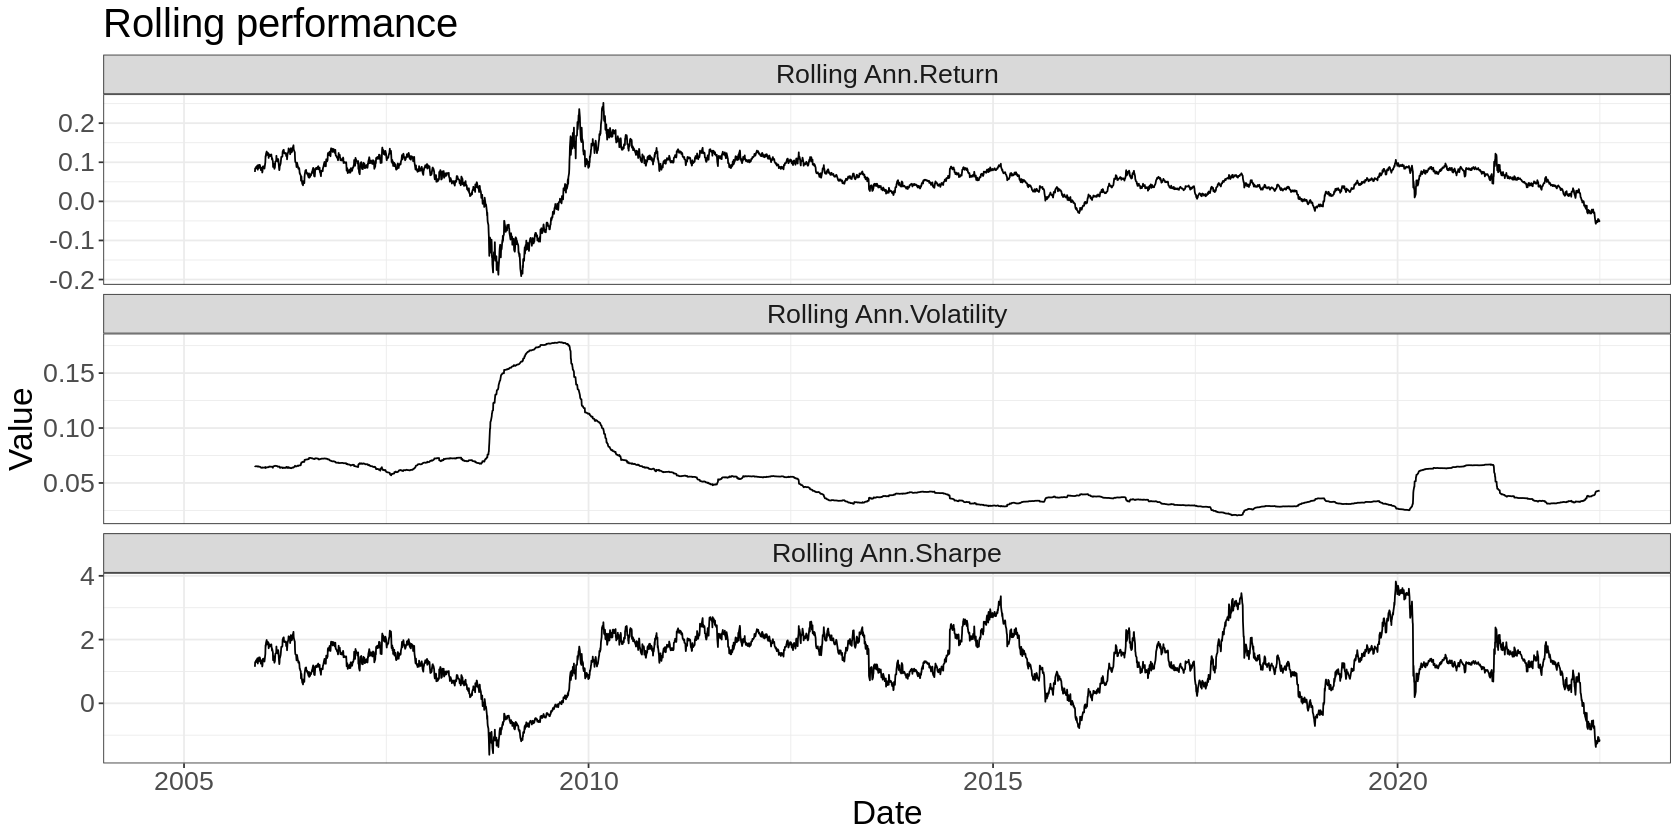

In [ ]:
# rolling portfolio performance
NAV %>%
  filter(ticker == "NAV") %>%
  arrange(date) %>%
  mutate(returns = log(exposure/dplyr::lag(exposure))) %>%
  na.omit() %>%
  mutate(
    `Rolling Ann.Return` = 252*roll::roll_mean(returns, width = 252, min_obs = 252),
    `Rolling Ann.Volatility` = sqrt(252)*roll::roll_sd(returns, width = 252, min_obs = 252),
    `Rolling Ann.Sharpe` = `Rolling Ann.Return`/`Rolling Ann.Volatility`
  ) %>%
  select(date, `Rolling Ann.Return`, `Rolling Ann.Volatility`, `Rolling Ann.Sharpe`) %>%
  pivot_longer(cols = c(-date), names_to = "metric", values_to = "value") %>%
  mutate(metric = factor(metric, levels = c("Rolling Ann.Return", "Rolling Ann.Volatility", "Rolling Ann.Sharpe"))) %>%
  ggplot(aes(x = date, y = value)) +
  geom_line() +
  facet_wrap(~metric, ncol = 1, scales = "free_y") +
  labs(
    title = "Rolling performance",
    x = "Date", 
    y = "Value"
  )

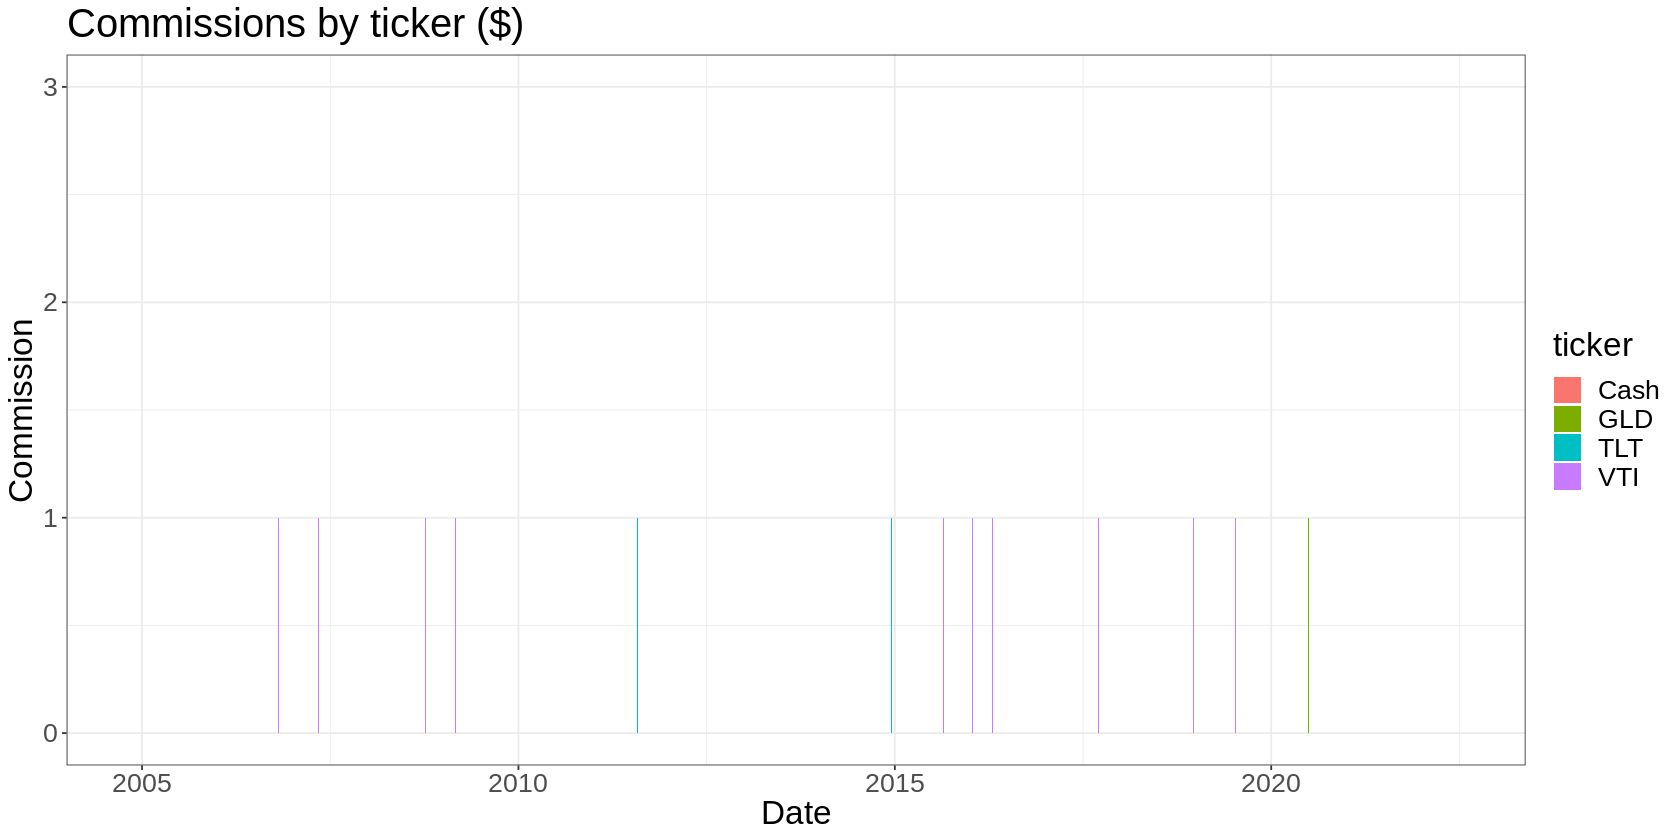

In [ ]:
# commissions by ticker over time
results_df %>%
  ggplot(aes(x = date, y = commission, fill = ticker)) + 
  geom_bar(stat = "identity") +
  labs(
    title = "Commissions by ticker ($)",
    x = "Date",
    y = "Commission"
  )

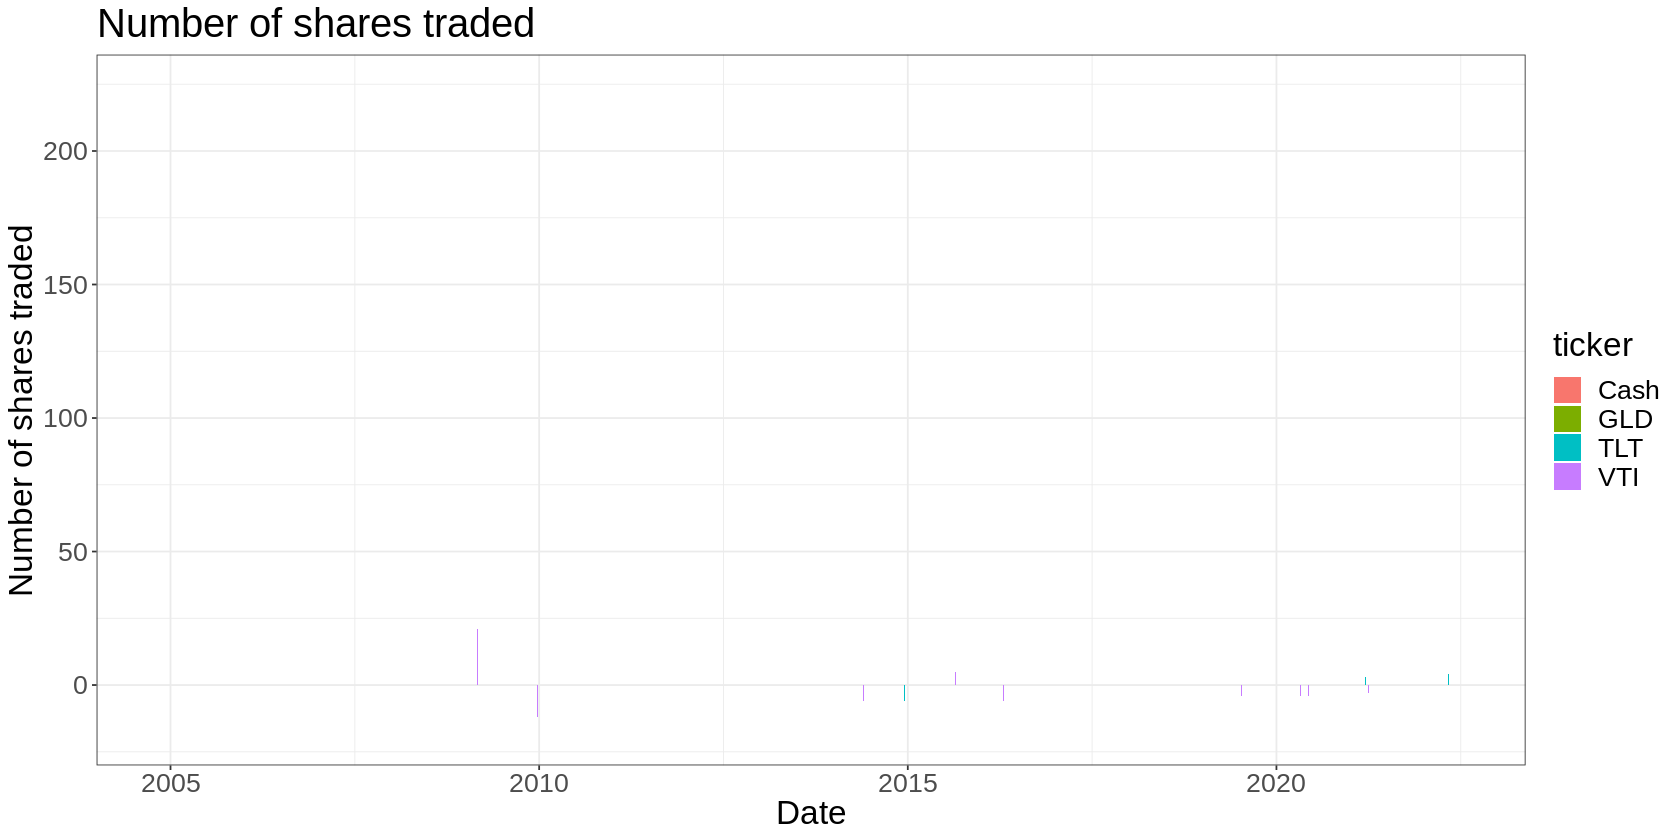

In [ ]:
# shares traded over time
results_df %>%
  ggplot(aes(x = date, y = share_trades, fill = ticker)) + 
  geom_bar(stat = "identity") +
  labs(
    title = "Number of shares traded",
    x = "Date",
    y = "Number of shares traded"
  )

The main trade-off here is in the settting of the trade boundary. 

Let's plot after cost performance by the trade boundary.



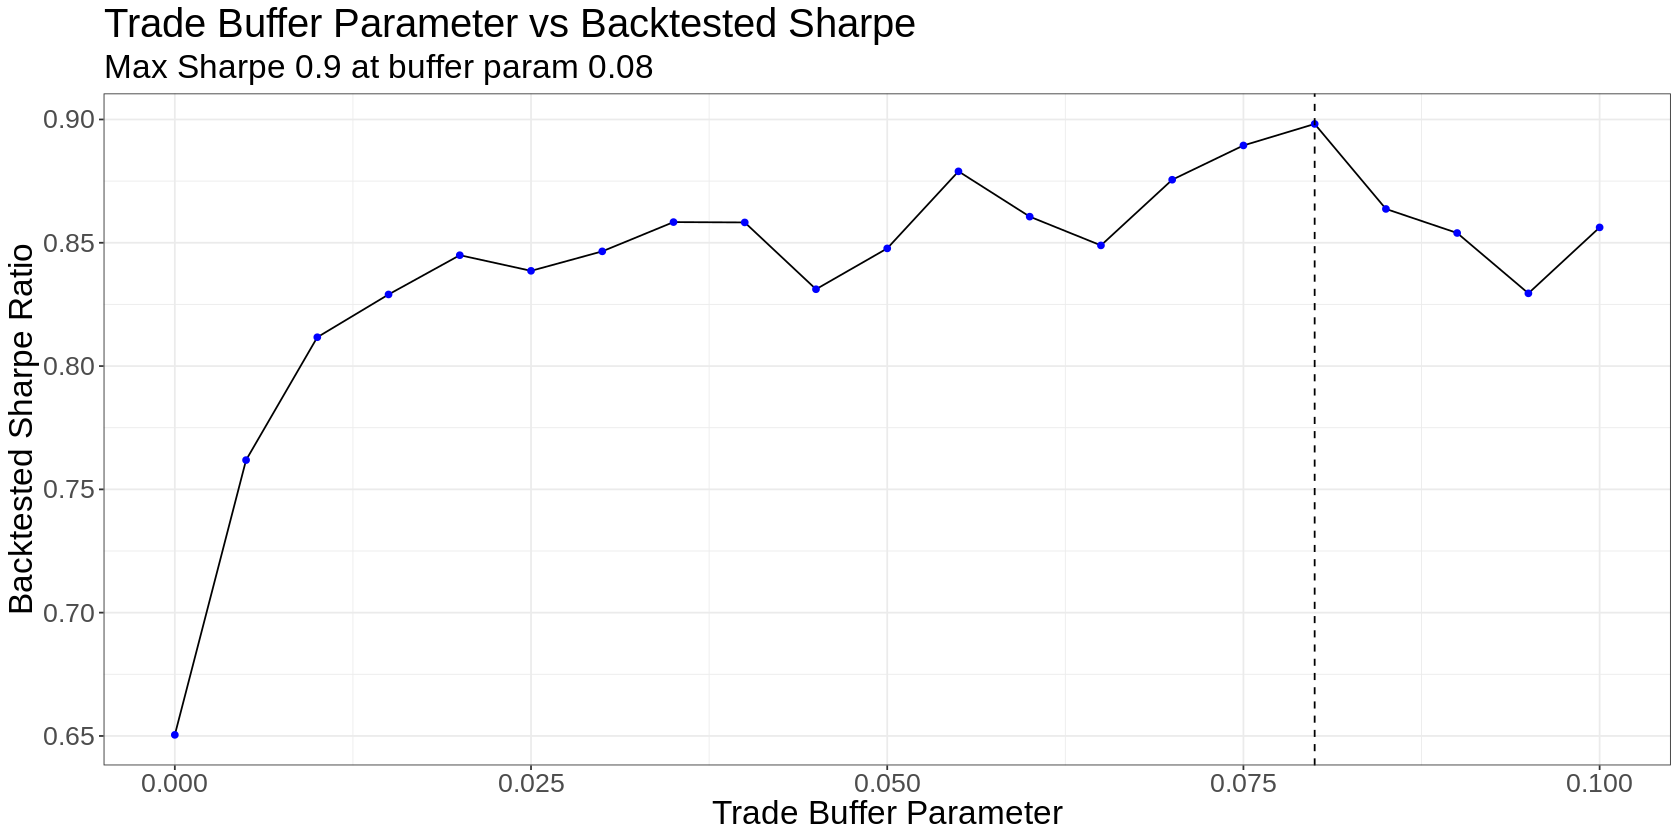

In [ ]:
# what value of trade buffer parameter would have given the optimal sharpe in the past?

trade_buffers <- seq(0, 0.1, 0.005)
sharpes <- list()

for(trade_buffer in trade_buffers) {
  results_df <- min_commission_backtest(
    prices = sim_prices,
    unadjusted_prices = sim_unadj_prices,
    target_weights = target_weights,
    interest_rates = interest_rates,
    short_borrow_costs = c("GLD" = 0.4/100, "TLT" = 0.4/100, "VTI" = 0.4/100),
    trade_buffer = trade_buffer,
    initial_cash = 10000,
    capitalise_profits = FALSE,
    commission_fun = us_tiered_commission,
    max_pct_per_order = 0.01,
    min_dollars_per_order = 1,
    dollars_per_share = 0.005
  )

  NAV <- results_df %>%
    group_by(date) %>%
    summarise(NAV = sum(exposure)) 

  sharpe <- NAV %>%
    mutate(returns = log(NAV/dplyr::lag(NAV))) %>%
      summarise(
        "Ann.Return(%)" = 252*mean(returns, na.rm = TRUE)*100,
        "Ann.Volatility(%)" = sqrt(252)*sd(returns, na.rm = TRUE)*100,
        "Ann.Sharpe" = `Ann.Return(%)`/`Ann.Volatility(%)`
      ) %>%
      pull(Ann.Sharpe)
  
  sharpes <- c(sharpes, sharpe)
}

sharpes <- unlist(sharpes)
data.frame(
  trade_buffer = trade_buffers, 
  sharpe = sharpes
) %>%
  ggplot(aes(x = trade_buffer, y = sharpe)) +
    geom_line() +
    geom_point(colour = "blue") +
    geom_vline(xintercept = trade_buffers[which.max(sharpes)], linetype = "dashed") +
    labs(
      x = "Trade Buffer Parameter",
      y = "Backtested Sharpe Ratio",
      title = glue("Trade Buffer Parameter vs Backtested Sharpe"),
      subtitle = glue("Max Sharpe {round(max(sharpes), 2)} at buffer param {trade_buffers[which.max(sharpes)]}")
    )

Our 5% buffer we first thought of seems like a reasonable choice.

### Continuously reinvesting profits at the portfolio level



In [ ]:
# simulation
results_df <- min_commission_backtest(
  prices = sim_prices,
  unadjusted_prices = sim_unadj_prices,
  target_weights = target_weights,
  interest_rates = interest_rates,
  short_borrow_costs = c("GLD" = 0.4/100, "TLT" = 0.4/100, "VTI" = 0.4/100),
  trade_buffer = 0.05,
  initial_cash = 10000,
  capitalise_profits = TRUE,
  commission_fun = us_tiered_commission,
  max_pct_per_order = 0.01,
  min_dollars_per_order = 1,
  dollars_per_share = 0.005
)

head(results_df)

ticker,date,close,shares,exposure,share_trades,trade_value,commission,interest,short_borrow,margin_call,reduced_target_pos
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
Cash,2004-11-18,0.00000,0,86.88975,0,-9910.545,0,0.434794521,0,FALSE,FALSE
GLD,2004-11-18,44.38000,33,1464.54003,33,1464.540,1,0.000000000,0,FALSE,FALSE
TLT,2004-11-18,50.17880,69,3462.33686,69,3462.337,1,0.000000000,0,FALSE,FALSE
VTI,2004-11-18,40.84974,122,4983.66816,122,4983.668,1,0.000000000,0,FALSE,FALSE
Cash,2004-11-19,0.00000,0,86.89353,0,0.000,0,0.003777919,0,FALSE,FALSE
GLD,2004-11-19,44.78000,33,1477.73997,0,0.000,0,0.000000000,0,FALSE,FALSE


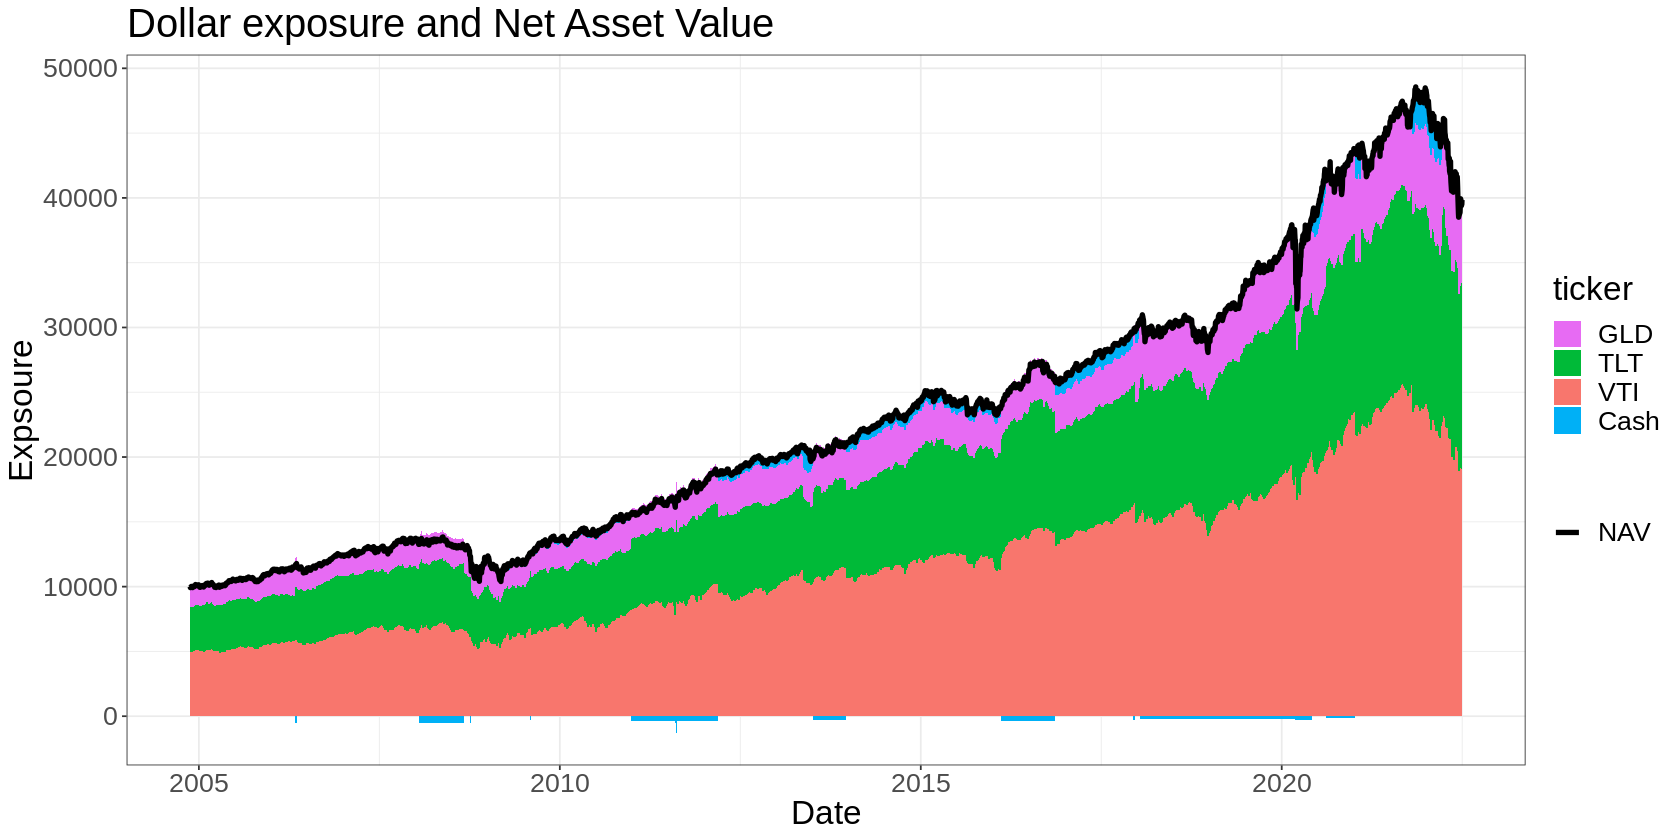

In [ ]:
# plot NAV and exposure by ticker
NAV <- results_df %>%
  group_by(date) %>%
  summarise(exposure = sum(exposure)) %>%
  mutate(ticker = "NAV")
  
NAV <- results_df %>%
  select(ticker, date, exposure) %>%
  bind_rows(NAV) %>%
  arrange(date, ticker) 
  
NAV %>%  
    filter(ticker != "NAV") %>%
    ggplot(aes(x = date, y = exposure, fill = ticker)) +
    geom_area() +
    scale_fill_manual(name = "ticker", values = c('#E76BF3', '#00BA38', '#F8766D', '#00b0f6'), limits = c('GLD', 'TLT', 'VTI', 'Cash')) +
    geom_line(data = NAV %>% dplyr::filter(ticker == "NAV"), aes(x = date, y = exposure, colour = "ticker"), linewidth = 1.5) +
    scale_colour_manual(values = "black", labels = "NAV") +
    labs(
      x = "Date",
      y = "Expsoure",
      title = "Dollar exposure and Net Asset Value",
      colour = ""
    )

In [ ]:
# summary stats
NAV %>%
  filter(ticker == "NAV") %>%
  arrange(date) %>%
  mutate(returns = log(exposure/dplyr::lag(exposure))) %>%
  na.omit() %>%
  summarise(
    `Ave.Ann.Return %` = round(100*mean(returns)*252, 2),
    `Ann.Volatility %` = round(100*sd(returns)*sqrt(252), 2),
    Sharpe = round(`Ave.Ann.Return %`/`Ann.Volatility %`, 2)
  )

Ave.Ann.Return %,Ann.Volatility %,Sharpe
<dbl>,<dbl>,<dbl>
7.86,9.7,0.81


Warning message:
“Removed 251 rows containing missing values (`geom_line()`).”


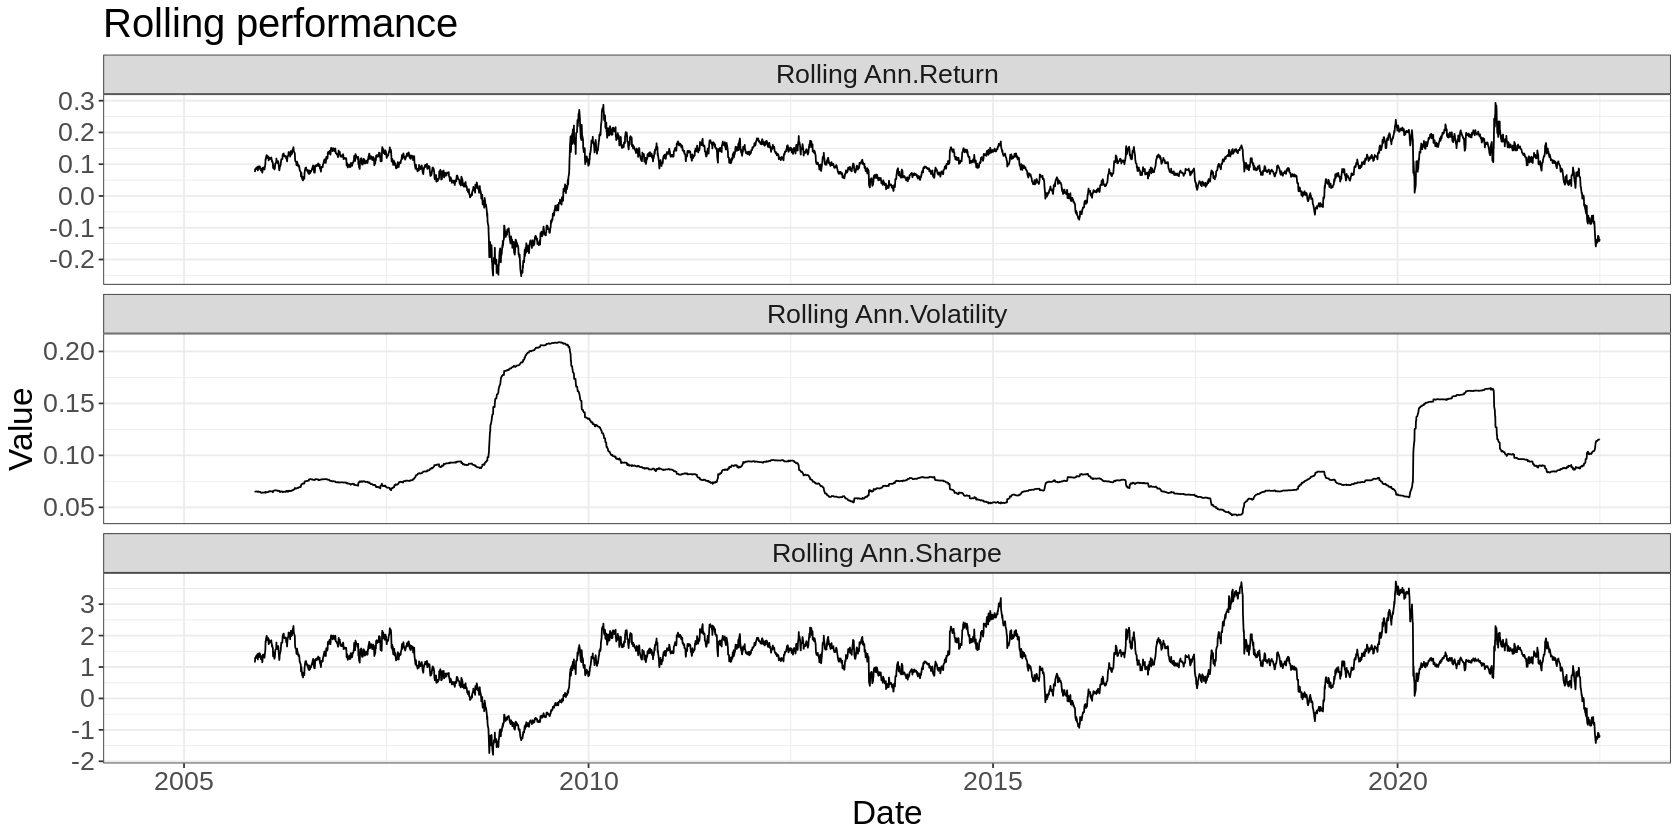

In [ ]:
# rolling portfolio performance
NAV %>%
  filter(ticker == "NAV") %>%
  arrange(date) %>%
  mutate(returns = log(exposure/dplyr::lag(exposure))) %>%
  na.omit() %>%
  mutate(
    `Rolling Ann.Return` = 252*roll::roll_mean(returns, width = 252, min_obs = 252),
    `Rolling Ann.Volatility` = sqrt(252)*roll::roll_sd(returns, width = 252, min_obs = 252),
    `Rolling Ann.Sharpe` = `Rolling Ann.Return`/`Rolling Ann.Volatility`
  ) %>%
  select(date, `Rolling Ann.Return`, `Rolling Ann.Volatility`, `Rolling Ann.Sharpe`) %>%
  pivot_longer(cols = c(-date), names_to = "metric", values_to = "value") %>%
  mutate(metric = factor(metric, levels = c("Rolling Ann.Return", "Rolling Ann.Volatility", "Rolling Ann.Sharpe"))) %>%
  ggplot(aes(x = date, y = value)) +
  geom_line() +
  facet_wrap(~metric, ncol = 1, scales = "free_y") +
  labs(
    title = "Rolling performance",
    x = "Date", 
    y = "Value"
  )

See how rolling vol is not diminishing anymore. 

We can use this to estimate the vol of our strategy at about 10% annualised (if fully invested with no leverage.)